## Trying to convert HDDM model object to ArviZ (waic)

Author: Hu Chuan-Peng (PhD)

Contact: hcp4715 AT hotmail.com

I used the example from [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html) to test the HDDM model, and tried to convert the HDDM model object to Arviz InferenceData.

In this script, I recorded the error I encountered after getting the point-wise log likelihood. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# redefined the `post_pred_gen`, see https://groups.google.com/g/hddm-users/c/Is6AM7eN0fo
from post_pred_gen_redifined import _parents_to_random_posterior_sample
from post_pred_gen_redifined import _post_pred_generate
from post_pred_gen_redifined import post_pred_gen

In [3]:
import sparse # test whether package `sparse` is installed; doesn't matter if not installed.

In [4]:
%matplotlib inline
import hddm
import kabuki
print("The current HDDM version is: ", hddm.__version__)

import arviz as az
import numpy as np
import pandas as pd
import xarray as xr

/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


The current HDDM version is:  0.8.0


## Loading data

In [5]:
# # find the directory of "cavanagh_theta_nn.csv"
# print(hddm.__file__)

In [6]:
!head /opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv

subj_idx,stim,rt,response,theta,dbs,conf
0,LL,1.21,1.0,0.65627512226100004,1,HC
0,WL,1.6299999999999999,1.0,-0.32788867166199998,1,LC
0,WW,1.03,1.0,-0.480284512399,1,HC
0,WL,2.77,1.0,1.9274273452399999,1,LC
0,WW,1.1399999999999999,0.0,-0.21323572605999999,1,HC
0,WL,1.1499999999999999,1.0,-0.43620365940099998,1,LC
0,LL,2.0,1.0,-0.27447891439400002,1,HC
0,WL,1.04,0.0,0.66695707371400004,1,LC
0,WW,0.85699999999999998,1.0,0.11861689909799999,1,HC


In [7]:
data = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


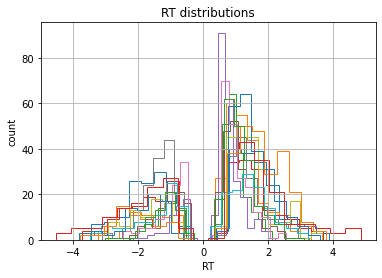

In [8]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

**NOTE:** Because for each condition there are different numbers of trials, I truncated the data so that the trials number for each condition is the minimum number now.

I also used the original data, the results is the same

In [9]:
# truncate the trials so that all conditions has the same number of trials
data['trial'] = data.groupby(['subj_idx', 'stim','conf']).cumcount()
min_trial_num = data.groupby(['subj_idx', 'stim', 'conf']).size().min()
data_trunc = data[data['trial']<=52].copy()

Check number of trials of each condition for each participant.

In [10]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

In [11]:
data_trunc.groupby(['subj_idx', 'stim', 'conf']).size()

subj_idx  stim  conf
0         LL    HC      53
          WL    LC      53
          WW    HC      53
1         LL    HC      53
          WL    LC      53
          WW    HC      53
2         LL    HC      53
          WL    LC      53
          WW    HC      53
3         LL    HC      53
          WL    LC      53
          WW    HC      53
4         LL    HC      53
          WL    LC      53
          WW    HC      53
5         LL    HC      53
          WL    LC      53
          WW    HC      53
6         LL    HC      53
          WL    LC      53
          WW    HC      53
7         LL    HC      53
          WL    LC      53
          WW    HC      53
8         LL    HC      53
          WL    LC      53
          WW    HC      53
9         LL    HC      53
          WL    LC      53
          WW    HC      53
10        LL    HC      53
          WL    LC      53
          WW    HC      53
11        LL    HC      53
          WL    LC      53
          WW    HC      53
12     

## Fitting a hierarchical model with four chains

#### Depends on stimulus

The original tutorial used code like this:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(2000, burn=500)
```

Here we tried two approaches for parallel processing, both need to first define a function for stimulus coding.

Here we will run multiple chains using pathos.

In [12]:
def parallel(func, *args, show=True, thread=False, **kwargs):
    """
    Parallel processing
    from Wan-Ke Pan, Shanghai Normal Uni, Shanghai, China.
    :param func: 函数，必选参数
    :param args: list/tuple/iterable,1个或多个函数的动态参数，必选参数
    :param show:bool, default is True, whether show the progress.
    :param thread:bool,默认False,是否为多线程
    :param kwargs:1个或多个函数的静态参数，key-word形式
    :return:list,与函数动态参数等长
    """
    import time
    from functools import partial
    from pathos.pools import ProcessPool, ThreadPool
    from tqdm import tqdm
    # 冻结静态参数
    p_func = partial(func, **kwargs)
    # 打开进程/线程池
    pool = ThreadPool() if thread else ProcessPool()
    try:
        if show:
            start = time.time()
            # imap方法
            with tqdm(total=len(args[0]), desc="计算进度") as t:  # 进度条设置 not really 
                r = []
                for i in pool.imap(p_func, *args):
                    r.append(i)
                    t.set_postfix({'并行函数': func.__name__, "计算花销": "%ds" % (time.time() - start)})
                    t.update()
        else:
          # map方法
          r = pool.map(p_func, *args)
        return r
    except Exception as e:
        print(e)
    finally:
        # 关闭池
        pool.close()  # close the pool to any new jobs
        pool.join()  # cleanup the closed worker processes
        pool.clear()  # Remove server with matching state

In [13]:
def mult_chain(df, chains=5, **argm):
    """
    mutliple chain in parallel, default samples=5000 burn=2000
    :param df: data
    :param chains: number of chains
    :return:a list of HDDM objects
    """
    import hddm
    # from third_module import parallel
    data_sets = [df] * chains
    def temp(df, **argm):
        import hddm
        m = hddm.HDDM(df, depends_on={'v': 'stim'}, **argm)
        samples = 2000
        burn = 500
        m.find_starting_values()
        m.sample(samples, burn, dbname='multi_chain', db='pickle')
        return m
    ms = parallel(temp, data_sets, **argm)
    # results = hddm.analyze.gelman_rubin(ms)
    return ms

In [14]:
def post_pred_par(ms, samples = 1500, **kwargs):
    import hddm
    
    def tmp_ppc(m, **argm):
        tmp_ppc = post_pred_gen(m, samples = samples)
        
        return tmp_ppc
    
    ppc_list = parallel(tmp_ppc, ms, samples = samples)
    
    return ppc_list

In [15]:
# define a function to run all the coverting
def model_to_arviz(df, **kwargs):
    """
    from data to arviz data
    """
    import arviz as az
    import numpy as np
    import pandas as pd
    import xarray as xr
    
    import hddm
    import kabuki
    
    # step 1: run model, list
    chains = 4
    samples=1500
    burn = 500
    ms = mult_chain(df, chains=chains)
    
    # step 2: get ppc, list
    ppc_list = post_pred_par(ms, samples=samples-burn)
    # ppc_list = parallel(post_pred_par, ms, samples=samples-burn)
    
    # step 3: get point-wise likelihoods, list
    data_grouped = df.groupby(['subj_idx', 'stim'])
    df_loglik = []
    
    for ii in range(len(ms)):
        tmp_posterior = ms[ii].get_traces()
        tmp_posterior['samples'] = np.arange(tmp_posterior.shape[0])
        # tmp_posterior.head()
        
        for group_name, df_grouped in data_grouped:
            tmp_df =data_grouped.get_group(group_name)
            tmp_df = np.array(tmp_df['rt'])

            a_colname = "a_subj." + str(group_name[0])
            t_colname = "t_subj." + str(group_name[0])
            v_colname = "v_subj(" + group_name[1] + ")." + str(group_name[0])

            for index, row in tmp_posterior.iterrows():
                tmp_a = row[a_colname]
                tmp_t = row[t_colname]
                tmp_v = row[v_colname]

                # Here we start using the pdf func of wfpt to calculate the likelihood
                obs = np.log(hddm.wfpt.pdf_array(x = tmp_df,
                                       v = np.array(tmp_v),
                                       a = np.array(tmp_a), 
                                       t = np.array(tmp_t),
                                       p_outlier = 0.05,
                                       sv = 0,
                                       z = 0.5,
                                       sz = 0,
                                       st = 0))
                tmp_df_pll = pd.DataFrame({'obs': obs,
                                           'draw': index,
                                           'subj_idx': group_name[0],
                                           'stim': group_name[1],
                                           'chain': ii})
                tmp_df_pll['trial'] = tmp_df_pll.groupby(['chain', 'draw', 'subj_idx', 'stim']).cumcount()
                df_loglik.append(tmp_df_pll)

    # step 4: Xarray
    # 4.1 observed
    obs_data_tmp = df.copy()
    obs_data_tmp['trial'] = obs_data_tmp.groupby(['subj_idx', 'stim']).cumcount()
    obs_data_tmp.drop(['theta','dbs','conf'], axis=1, inplace=True)
    obs_data_tmp = obs_data_tmp.set_index(["subj_idx", "stim", 'trial'])
    xdata_observed = xr.Dataset.from_dataframe(obs_data_tmp, sparse=True)
    
    # 4.2 posterior
    df_traces = []
    for jj in range(len(ms)):
        m = ms[jj]
        trace_tmp = m.get_traces()
        trace_tmp['chain'] = jj
        trace_tmp['draw'] = np.arange(len(trace_tmp), dtype=int)
        print('chain', jj, trace_tmp.shape)
        df_traces.append(trace_tmp)
    df_traces = pd.concat(df_traces)
    df_traces = df_traces.set_index(["chain", "draw"])
    xdata_posterior = xr.Dataset.from_dataframe(df_traces)
    
    # 4.3 posterior predictive
    df_ppc = []
    for kk in range(len(ppc_list)):
        ppc_tmp = ppc_list[kk]
    #     df_post_pred = hddm.utils.post_pred_gen(m, samples = 1500)
        ppc_tmp.reset_index(inplace=True)
        ppc_tmp['chain'] = kk
        ppc_tmp.rename(columns={'sample':'draw',
                            'level_2':'trial'}, inplace=True)
        print('\nchain', kk, ppc_tmp.shape)

        ppc_tmp[['stim', 'subj_idx']] = ppc_tmp['node'].str.split(pat='\.', expand=True)

        # extract the stim string between "(" and ")"

        ppc_tmp['stim'] = ppc_tmp['stim'].str.extract('.*\((.*)\).*')
        ppc_tmp.drop('node', axis=1, inplace=True)
        df_ppc.append(ppc_tmp)
        
    df_ppc = pd.concat(df_ppc)
    xdata_post_pred = xr.Dataset.from_dataframe(df_ppc)
    
    # point-wise log lik
    df_loglik = pd.concat(df_loglik)
    df_loglik = df_loglik.set_index(["chain", "draw",'subj_idx', 'stim', 'trial'])
    xdata_loglik = xr.Dataset.from_dataframe(df_loglik)
    
    # convert to InferenceData
    print("start to convert to Inference data.\n")
    InfData = az.InferenceData(posterior=xdata_posterior, 
                               observed_data=xdata_observed,
                               posterior_predictive=xdata_post_pred,
                               log_likelihood = xdata_loglik)

    return InfData

In [16]:
InfData_2 = model_to_arviz(data_trunc) # get the InferenceData from truncated data

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 -                 5%                  ] 101 of 2000 complete in 11.6 sec                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 11 of 2000 complete in 1.1 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 16 of 2000 complete in 1.7 sec[                  0%                  ] 16 of 2000 complete in 1.7 sec[                  0%                  ] 16 of 2000 complete in 1.8 sec[                  0%                  ] 16 of 2000 complete in 1.8 sec[                  1%                  ] 21 of 2000 complete in 2.2 sec[                  1%                  ] 21 of 2000 complete in 2.3 sec[                  1%                  ] 21 of 2000 complete in 2.3 sec[      

 [--                7%                  ] 151 of 2000 complete in 17.4 sec[--                7%                  ] 149 of 2000 complete in 17.5 sec[--                7%                  ] 151 of 2000 complete in 17.5 sec[--                7%                  ] 153 of 2000 complete in 17.8 sec[--                7%                  ] 156 of 2000 complete in 17.9 sec[--                7%                  ] 154 of 2000 complete in 18.0 sec[--                7%                  ] 156 of 2000 complete in 18.1 sec[---               7%                  ] 158 of 2000 complete in 18.4 sec[---               8%                  ] 161 of 2000 complete in 18.5 sec[---               7%                  ] 159 of 2000 complete in 18.6 sec[---               8%                  ] 161 of 2000 complete in 18.7 sec[---               8%                  ] 163 of 2000 complete in 19.0 sec[---               8%                  ] 166 of 2000 complete in 19.1 sec[---               8%                  ] 164 of 20

 [-----            14%                  ] 288 of 2000 complete in 33.8 sec[-----            14%                  ] 288 of 2000 complete in 33.7 sec[-----            14%                  ] 291 of 2000 complete in 34.0 sec[-----            14%                  ] 296 of 2000 complete in 34.3 sec[-----            14%                  ] 293 of 2000 complete in 34.4 sec[-----            14%                  ] 293 of 2000 complete in 34.4 sec[-----            14%                  ] 296 of 2000 complete in 34.6 sec[-----            15%                  ] 301 of 2000 complete in 34.9 sec[-----            14%                  ] 298 of 2000 complete in 35.0 sec[-----            14%                  ] 298 of 2000 complete in 35.0 sec[-----            15%                  ] 301 of 2000 complete in 35.2 sec[-----            15%                  ] 306 of 2000 complete in 35.5 sec[-----            15%                  ] 303 of 2000 complete in 35.6 sec[-----            15%                  ] 303 of 20

 [--------         21%                  ] 426 of 2000 complete in 50.0 sec[--------         21%                  ] 432 of 2000 complete in 50.4 sec[--------         21%                  ] 436 of 2000 complete in 50.5 sec[--------         21%                  ] 430 of 2000 complete in 50.5 sec[--------         21%                  ] 431 of 2000 complete in 50.6 sec[--------         22%                  ] 441 of 2000 complete in 51.1 sec[--------         21%                  ] 437 of 2000 complete in 51.0 sec[--------         21%                  ] 435 of 2000 complete in 51.1 sec[--------         21%                  ] 436 of 2000 complete in 51.2 sec[--------         22%                  ] 446 of 2000 complete in 51.6 sec[--------         22%                  ] 442 of 2000 complete in 51.6 sec[--------         22%                  ] 440 of 2000 complete in 51.7 sec[--------         22%                  ] 441 of 2000 complete in 51.8 sec[--------         22%                  ] 451 of 20

 ------------     32%                  ] 643 of 2000 complete in 75.7 secc[----------       28%                  ] 568 of 2000 complete in 66.8 sec[----------       28%                  ] 570 of 2000 complete in 66.9 sec[----------       28%                  ] 571 of 2000 complete in 66.8 sec[----------       28%                  ] 577 of 2000 complete in 67.0 sec[----------       28%                  ] 573 of 2000 complete in 67.4 sec[----------       28%                  ] 574 of 2000 complete in 67.4 sec[----------       28%                  ] 576 of 2000 complete in 67.4 sec[-----------      29%                  ] 582 of 2000 complete in 67.6 sec[----------       28%                  ] 577 of 2000 complete in 67.9 sec[-----------      28%                  ] 579 of 2000 complete in 68.0 sec[-----------      29%                  ] 586 of 2000 complete in 68.1 sec[-----------      29%                  ] 581 of 2000 complete in 68.0 sec[-----------      29%                  ] 582 of 20

 -------------    35%                  ] 701 of 2000 complete in 83.3 sec [-------------    35%                  ] 705 of 2000 complete in 83.2 sec[-------------    35%                  ] 704 of 2000 complete in 83.3 sec[-------------    35%                  ] 711 of 2000 complete in 83.5 sec[-------------    35%                  ] 705 of 2000 complete in 83.8 sec[-------------    35%                  ] 708 of 2000 complete in 83.8 sec[-------------    35%                  ] 710 of 2000 complete in 83.8 sec[-------------    35%                  ] 716 of 2000 complete in 84.1 sec[-------------    35%                  ] 709 of 2000 complete in 84.3 sec[-------------    35%                  ] 713 of 2000 complete in 84.4 sec[-------------    35%                  ] 715 of 2000 complete in 84.4 sec[-------------    36%                  ] 721 of 2000 complete in 84.7 sec[-------------    35%                  ] 714 of 2000 complete in 84.9 sec[-------------    35%                  ] 718 of 20

 [---------------  41%                  ] 835 of 2000 complete in 99.2 sec[---------------  41%                  ] 836 of 2000 complete in 99.6 sec[---------------  41%                  ] 839 of 2000 complete in 99.7 sec[---------------- 42%                  ] 844 of 2000 complete in 99.8 sec[---------------  41%                  ] 835 of 2000 complete in 99.8 sec[---------------  42%                  ] 840 of 2000 complete in 100.1 sec[---------------- 42%                  ] 843 of 2000 complete in 100.2 sec[---------------- 42%                  ] 849 of 2000 complete in 100.4 sec[---------------  42%                  ] 840 of 2000 complete in 100.4 sec[---------------- 42%                  ] 844 of 2000 complete in 100.6 sec[---------------- 42%                  ] 847 of 2000 complete in 100.7 sec[---------------- 42%                  ] 853 of 2000 complete in 100.9 sec[---------------- 42%                  ] 845 of 2000 complete in 101.0 sec[---------------- 42%                  ] 8

 -----------------49%                  ] 983 of 2000 complete in 116.5 secc[-----------------48%                  ] 968 of 2000 complete in 115.5 sec[-----------------48%                  ] 964 of 2000 complete in 115.6 sec[-----------------48%                  ] 978 of 2000 complete in 115.9 sec[-----------------48%                  ] 969 of 2000 complete in 115.9 sec[-----------------48%                  ] 972 of 2000 complete in 116.0 sec[-----------------48%                  ] 968 of 2000 complete in 116.1 sec [-----------------48%                  ] 973 of 2000 complete in 116.4 sec[-----------------48%                  ] 977 of 2000 complete in 116.6 sec[-----------------48%                  ] 973 of 2000 complete in 116.7 sec[-----------------48%                  ] 977 of 2000 complete in 116.9 sec[-----------------49%                  ] 988 of 2000 complete in 117.1 sec[-----------------48%                  ] 977 of 2000 complete in 117.3 sec[-----------------49%               

 [-----------------55%                  ] 1101 of 2000 complete in 131.1 sec[-----------------54%                  ] 1096 of 2000 complete in 131.2 sec[-----------------54%                  ] 1088 of 2000 complete in 131.2 sec[-----------------54%                  ] 1092 of 2000 complete in 131.4 sec[-----------------55%-                 ] 1106 of 2000 complete in 131.7 sec[-----------------54%                  ] 1092 of 2000 complete in 131.7 sec[-----------------55%                  ] 1101 of 2000 complete in 131.7 sec[-----------------54%                  ] 1097 of 2000 complete in 132.0 sec[-----------------55%-                 ] 1111 of 2000 complete in 132.3 sec[-----------------54%                  ] 1097 of 2000 complete in 132.4 sec[-----------------55%-                 ] 1106 of 2000 complete in 132.3 sec[-----------------55%                  ] 1101 of 2000 complete in 132.5 sec[-----------------55%-                 ] 1115 of 2000 complete in 132.8 sec[-----------------55%   

 [-----------------60%---               ] 1211 of 2000 complete in 146.6 sec[-----------------60%---               ] 1216 of 2000 complete in 146.8 sec[-----------------61%---               ] 1225 of 2000 complete in 146.9 sec[-----------------61%---               ] 1229 of 2000 complete in 147.1 sec[-----------------60%---               ] 1216 of 2000 complete in 147.2 sec[-----------------61%---               ] 1221 of 2000 complete in 147.4 sec[-----------------61%---               ] 1230 of 2000 complete in 147.5 sec[-----------------61%---               ] 1234 of 2000 complete in 147.7 sec[-----------------61%---               ] 1221 of 2000 complete in 147.8 sec[-----------------61%---               ] 1234 of 2000 complete in 148.0 sec[-----------------61%---               ] 1226 of 2000 complete in 148.0 sec[-----------------61%---               ] 1239 of 2000 complete in 148.3 sec[-----------------61%---               ] 1226 of 2000 complete in 148.4 sec[-----------------61%---

 [-----------------67%-----             ] 1353 of 2000 complete in 162.3 sec[-----------------67%-----             ] 1352 of 2000 complete in 162.5 sec[-----------------67%-----             ] 1342 of 2000 complete in 162.6 sec[-----------------67%-----             ] 1357 of 2000 complete in 162.9 sec[-----------------67%-----             ] 1341 of 2000 complete in 162.9 sec[-----------------67%-----             ] 1357 of 2000 complete in 163.1 sec[-----------------67%-----             ] 1346 of 2000 complete in 163.1 sec[-----------------68%-----             ] 1361 of 2000 complete in 163.4 sec[-----------------67%-----             ] 1346 of 2000 complete in 163.5 sec[-----------------68%-----             ] 1361 of 2000 complete in 163.6 sec[-----------------67%-----             ] 1351 of 2000 complete in 163.7 sec[-----------------68%-----             ] 1366 of 2000 complete in 164.0 sec[-----------------67%-----             ] 1351 of 2000 complete in 164.1 sec[-----------------68%---

 [-----------------73%--------          ] 1475 of 2000 complete in 177.9 sec[-----------------73%-------           ] 1462 of 2000 complete in 178.0 sec[-----------------73%-------           ] 1467 of 2000 complete in 178.1 sec[-----------------74%--------          ] 1481 of 2000 complete in 178.2 sec[-----------------74%--------          ] 1480 of 2000 complete in 178.5 sec[-----------------73%-------           ] 1467 of 2000 complete in 178.6 sec[-----------------74%--------          ] 1485 of 2000 complete in 178.7 sec[-----------------73%-------           ] 1472 of 2000 complete in 178.7 sec[-----------------73%-------           ] 1471 of 2000 complete in 179.2 sec[-----------------74%--------          ] 1485 of 2000 complete in 179.2 sec[-----------------74%--------          ] 1489 of 2000 complete in 179.2 sec[-----------------73%--------          ] 1477 of 2000 complete in 179.3 sec[-----------------73%--------          ] 1475 of 2000 complete in 179.7 sec[-----------------74%---

 [-----------------80%----------        ] 1601 of 2000 complete in 193.2 sec[-----------------79%----------        ] 1597 of 2000 complete in 193.3 sec[-----------------79%----------        ] 1593 of 2000 complete in 193.3 sec[-----------------79%----------        ] 1587 of 2000 complete in 193.7 sec[-----------------80%----------        ] 1606 of 2000 complete in 193.8 sec[-----------------80%----------        ] 1602 of 2000 complete in 193.9 sec[-----------------79%----------        ] 1598 of 2000 complete in 193.9 sec[-----------------79%----------        ] 1592 of 2000 complete in 194.3 sec[-----------------80%----------        ] 1610 of 2000 complete in 194.4 sec[-----------------80%----------        ] 1606 of 2000 complete in 194.4 sec[-----------------80%----------        ] 1603 of 2000 complete in 194.5 sec[-----------------79%----------        ] 1597 of 2000 complete in 194.9 sec[-----------------80%----------        ] 1615 of 2000 complete in 195.0 sec[-----------------80%---

 -----------------89%-------------     ] 1785 of 2000 complete in 217.1 secc[-----------------85%------------      ] 1711 of 2000 complete in 209.2 sec[-----------------86%------------      ] 1729 of 2000 complete in 209.2 sec[-----------------86%------------      ] 1725 of 2000 complete in 209.5 sec[-----------------86%------------      ] 1733 of 2000 complete in 209.6 sec[-----------------85%------------      ] 1716 of 2000 complete in 209.8 sec[-----------------86%------------      ] 1734 of 2000 complete in 209.8 sec[-----------------86%------------      ] 1729 of 2000 complete in 210.0 sec[-----------------86%-------------     ] 1737 of 2000 complete in 210.1 sec[-----------------86%------------      ] 1720 of 2000 complete in 210.3 sec[-----------------86%-------------     ] 1739 of 2000 complete in 210.4 sec[-----------------86%------------      ] 1733 of 2000 complete in 210.5 sec[-----------------87%-------------     ] 1741 of 2000 complete in 210.6 sec[-----------------86%---

 [-----------------92%---------------   ] 1854 of 2000 complete in 224.4 sec[-----------------92%---------------   ] 1853 of 2000 complete in 224.6 sec[-----------------91%--------------    ] 1836 of 2000 complete in 224.9 sec[-----------------92%---------------   ] 1847 of 2000 complete in 224.9 sec[-----------------92%---------------   ] 1859 of 2000 complete in 225.1 sec[-----------------92%---------------   ] 1857 of 2000 complete in 225.1 sec[-----------------92%--------------    ] 1841 of 2000 complete in 225.6 sec[-----------------92%---------------   ] 1852 of 2000 complete in 225.5 sec[-----------------93%---------------   ] 1864 of 2000 complete in 225.6 sec[-----------------93%---------------   ] 1862 of 2000 complete in 225.7 sec[-----------------92%---------------   ] 1845 of 2000 complete in 226.1 sec[-----------------92%---------------   ] 1857 of 2000 complete in 226.1 sec[-----------------93%---------------   ] 1869 of 2000 complete in 226.2 sec[-----------------93%---

[-----------------100%-----------------] 2000 of 2000 complete in 245.5 secc[-----------------98%----------------- ] 1972 of 2000 complete in 240.1 sec[-----------------97%----------------- ] 1959 of 2000 complete in 240.3 sec[-----------------98%----------------- ] 1977 of 2000 complete in 240.4 sec[-----------------99%----------------- ] 1986 of 2000 complete in 240.8 sec[-----------------98%----------------- ] 1963 of 2000 complete in 240.8 sec[-----------------98%----------------- ] 1977 of 2000 complete in 240.7 sec[-----------------99%----------------- ] 1982 of 2000 complete in 241.0 sec[-----------------98%----------------- ] 1967 of 2000 complete in 241.3 sec[-----------------99%----------------- ] 1990 of 2000 complete in 241.3 sec[-----------------99%----------------- ] 1981 of 2000 complete in 241.2 sec[-----------------99%----------------- ] 1987 of 2000 complete in 241.7 sec[-----------------98%----------------- ] 1971 of 2000 complete in 241.8 sec[-----------------99%---

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]

 [---               9%                  ] 4 of 42 complete in 12.8 sec[---               9%                  ] 4 of 42 complete in 12.8 sec[---               9%                  ] 4 of 42 complete in 12.8 sec[---               9%                  ] 4 of 42 complete in 12.9 sec[----             11%                  ] 5 of 42 complete in 25.6 sec[----             11%                  ] 5 of 42 complete in 25.6 sec[----             11%                  ] 5 of 42 complete in 25.7 sec[----             11%                  ] 5 of 42 complete in 25.8 sec[-----            14%                  ] 6 of 42 complete in 37.3 sec[-----            14%                  ] 6 of 42 complete in 37.4 sec[-----            14%                  ] 6 of 42 complete in 37.4 sec[-----            14%                  ] 6 of 42 complete in 37.5 sec[------           16%                  ] 7 of 42 complete in 50.1 sec[------           16%                  ] 7 of 42 complete in 50.1 sec[------           16%            

 [-----------------78%---------         ] 33 of 42 complete in 372.3 sec[-----------------78%---------         ] 33 of 42 complete in 372.2 sec[-----------------78%---------         ] 33 of 42 complete in 374.5 sec[-----------------80%----------        ] 34 of 42 complete in 382.9 sec[-----------------80%----------        ] 34 of 42 complete in 383.8 sec[-----------------80%----------        ] 34 of 42 complete in 383.8 sec[-----------------80%----------        ] 34 of 42 complete in 386.2 sec[-----------------83%-----------       ] 35 of 42 complete in 395.6 sec[-----------------83%-----------       ] 35 of 42 complete in 396.5 sec[-----------------83%-----------       ] 35 of 42 complete in 396.6 sec[-----------------83%-----------       ] 35 of 42 complete in 399.0 sec[-----------------85%------------      ] 36 of 42 complete in 407.3 sec[-----------------85%------------      ] 36 of 42 complete in 408.1 sec[-----------------85%------------      ] 36 of 42 complete in 408.3 sec[----

计算进度:  25%|██▌       | 1/4 [08:41<26:05, 521.74s/it, 并行函数=tmp_ppc, 计算花销=521s]

 [------------------107%------------------] 45 of 42 complete in 521.1 sec[------------------107%------------------] 45 of 42 complete in 523.9 sec

计算进度: 100%|██████████| 4/4 [08:45<00:00, 131.35s/it, 并行函数=tmp_ppc, 计算花销=525s]


chain 0 (1500, 80)
chain 1 (1500, 80)
chain 2 (1500, 80)
chain 3 (1500, 80)

chain 0 (2226000, 6)

chain 1 (2226000, 6)

chain 2 (2226000, 6)

chain 3 (2226000, 6)
start to convert to Inference data.



In [17]:
InfData_1 = model_to_arviz(data)

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 5 of 2000 complete in 0.5 sec[                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 10 of 2000 complete in 1.1 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 16 of 2000 complete in 1.7 sec[                  0%                  ] 16 of 2000 complete in 1.8 sec[                  0%                  ] 15 of 2000 complete in 1.7 sec[                  0%                  ] 16 of 2000 complete in 1.8 sec[                  1%                  ] 21 of 2000 complete in 2.3 sec[                  1%                  ] 21 of 2000 complete in 2.3 sec[        

 [--                7%                  ] 144 of 2000 complete in 17.1 sec[--                7%                  ] 151 of 2000 complete in 17.4 sec[--                7%                  ] 151 of 2000 complete in 17.4 sec[--                7%                  ] 150 of 2000 complete in 17.6 sec[--                7%                  ] 149 of 2000 complete in 17.7 sec[--                7%                  ] 156 of 2000 complete in 18.0 sec[--                7%                  ] 156 of 2000 complete in 18.0 sec[--                7%                  ] 155 of 2000 complete in 18.2 sec[--                7%                  ] 154 of 2000 complete in 18.3 sec[---               8%                  ] 161 of 2000 complete in 18.5 sec[---               8%                  ] 161 of 2000 complete in 18.6 sec[---               8%                  ] 160 of 2000 complete in 18.8 sec[---               7%                  ] 159 of 2000 complete in 18.9 sec[---               8%                  ] 166 of 20

 [-----            14%                  ] 285 of 2000 complete in 33.5 sec[-----            14%                  ] 281 of 2000 complete in 33.6 sec[-----            14%                  ] 284 of 2000 complete in 33.8 sec[-----            14%                  ] 291 of 2000 complete in 33.9 sec[-----            14%                  ] 290 of 2000 complete in 34.1 sec[-----            14%                  ] 286 of 2000 complete in 34.2 sec[-----            14%                  ] 289 of 2000 complete in 34.4 sec[-----            14%                  ] 296 of 2000 complete in 34.5 sec[-----            14%                  ] 290 of 2000 complete in 34.7 sec[-----            14%                  ] 295 of 2000 complete in 34.8 sec[-----            14%                  ] 293 of 2000 complete in 34.9 sec[-----            15%                  ] 301 of 2000 complete in 35.1 sec[-----            14%                  ] 294 of 2000 complete in 35.2 sec[-----            14%                  ] 299 of 20

 [-------          20%                  ] 408 of 2000 complete in 49.3 sec[-------          21%                  ] 420 of 2000 complete in 49.8 sec[-------          20%                  ] 417 of 2000 complete in 49.9 sec[-------          20%                  ] 416 of 2000 complete in 50.0 sec[-------          20%                  ] 413 of 2000 complete in 49.9 sec[--------         21%                  ] 424 of 2000 complete in 50.3 sec[-------          20%                  ] 417 of 2000 complete in 50.4 sec[--------         21%                  ] 422 of 2000 complete in 50.5 sec[-------          21%                  ] 421 of 2000 complete in 50.6 sec[--------         21%                  ] 428 of 2000 complete in 50.8 sec[-------          21%                  ] 421 of 2000 complete in 50.9 sec[--------         21%                  ] 425 of 2000 complete in 51.1 sec[--------         21%                  ] 427 of 2000 complete in 51.1 sec[--------         21%                  ] 432 of 20

 [----------       27%                  ] 547 of 2000 complete in 65.6 sec[----------       27%                  ] 542 of 2000 complete in 65.6 sec[----------       26%                  ] 539 of 2000 complete in 65.7 sec[----------       27%                  ] 546 of 2000 complete in 65.9 sec[----------       27%                  ] 546 of 2000 complete in 66.1 sec[----------       27%                  ] 552 of 2000 complete in 66.2 sec[----------       27%                  ] 543 of 2000 complete in 66.2 sec[----------       27%                  ] 551 of 2000 complete in 66.5 sec[----------       27%                  ] 550 of 2000 complete in 66.6 sec[----------       27%                  ] 557 of 2000 complete in 66.8 sec[----------       27%                  ] 547 of 2000 complete in 66.8 sec[----------       27%                  ] 556 of 2000 complete in 67.1 sec[----------       27%                  ] 555 of 2000 complete in 67.3 sec[----------       27%                  ] 551 of 20

 [------------     33%                  ] 664 of 2000 complete in 81.3 sec[------------     33%                  ] 668 of 2000 complete in 81.4 sec[------------     33%                  ] 676 of 2000 complete in 81.6 sec[------------     33%                  ] 671 of 2000 complete in 81.6 sec[------------     33%                  ] 668 of 2000 complete in 81.8 sec[------------     33%                  ] 672 of 2000 complete in 82.0 sec[------------     34%                  ] 680 of 2000 complete in 82.1 sec[------------     33%                  ] 676 of 2000 complete in 82.2 sec[------------     33%                  ] 672 of 2000 complete in 82.3 sec[------------     33%                  ] 677 of 2000 complete in 82.6 sec[-------------    34%                  ] 685 of 2000 complete in 82.7 sec[------------     33%                  ] 676 of 2000 complete in 82.8 sec[------------     34%                  ] 681 of 2000 complete in 82.8 sec[------------     34%                  ] 682 of 20

 [---------------  39%                  ] 798 of 2000 complete in 97.5 sec[---------------  40%                  ] 800 of 2000 complete in 97.5 sec[---------------  39%                  ] 795 of 2000 complete in 97.6 sec[---------------  40%                  ] 807 of 2000 complete in 97.8 sec[---------------  40%                  ] 802 of 2000 complete in 98.0 sec[---------------  40%                  ] 804 of 2000 complete in 98.0 sec[---------------  39%                  ] 799 of 2000 complete in 98.1 sec[---------------  40%                  ] 812 of 2000 complete in 98.4 sec[---------------  40%                  ] 807 of 2000 complete in 98.6 sec[---------------  40%                  ] 803 of 2000 complete in 98.6 sec[---------------  40%                  ] 809 of 2000 complete in 98.6 sec[---------------  40%                  ] 817 of 2000 complete in 99.0 sec[---------------  40%                  ] 811 of 2000 complete in 99.1 sec[---------------  40%                  ] 807 of 20

 [-----------------46%                  ] 923 of 2000 complete in 113.0 sec[-----------------45%                  ] 919 of 2000 complete in 113.0 sec[-----------------46%                  ] 927 of 2000 complete in 113.4 sec[-----------------46%                  ] 934 of 2000 complete in 113.6 sec[-----------------46%                  ] 928 of 2000 complete in 113.7 sec[-----------------46%                  ] 924 of 2000 complete in 113.6 sec[-----------------46%                  ] 932 of 2000 complete in 114.0 sec[-----------------46%                  ] 932 of 2000 complete in 114.2 sec[-----------------46%                  ] 939 of 2000 complete in 114.2 sec[-----------------46%                  ] 929 of 2000 complete in 114.2 sec[-----------------46%                  ] 936 of 2000 complete in 114.5 sec[-----------------46%                  ] 936 of 2000 complete in 114.7 sec[-----------------46%                  ] 933 of 2000 complete in 114.7 sec[-----------------47%                

 [-----------------52%                  ] 1057 of 2000 complete in 128.9 sec[-----------------52%                  ] 1053 of 2000 complete in 129.1 sec[-----------------52%                  ] 1045 of 2000 complete in 129.0 sec[-----------------52%                  ] 1055 of 2000 complete in 129.2 sec[-----------------53%                  ] 1062 of 2000 complete in 129.5 sec[-----------------52%                  ] 1049 of 2000 complete in 129.5 sec[-----------------52%                  ] 1058 of 2000 complete in 129.7 sec[-----------------53%                  ] 1060 of 2000 complete in 129.8 sec[-----------------53%                  ] 1067 of 2000 complete in 130.1 sec[-----------------53%                  ] 1062 of 2000 complete in 130.2 sec[-----------------52%                  ] 1054 of 2000 complete in 130.1 sec[-----------------53%                  ] 1065 of 2000 complete in 130.4 sec[-----------------53%                  ] 1072 of 2000 complete in 130.7 sec[-----------------52%   

 [-----------------58%--                ] 1173 of 2000 complete in 144.3 sec[-----------------59%--                ] 1184 of 2000 complete in 144.7 sec[-----------------58%--                ] 1172 of 2000 complete in 144.7 sec[-----------------58%--                ] 1177 of 2000 complete in 144.8 sec[-----------------59%--                ] 1180 of 2000 complete in 144.8 sec[-----------------59%--                ] 1188 of 2000 complete in 145.2 sec[-----------------58%--                ] 1176 of 2000 complete in 145.2 sec[-----------------59%--                ] 1182 of 2000 complete in 145.5 sec[-----------------59%--                ] 1185 of 2000 complete in 145.4 sec[-----------------59%--                ] 1192 of 2000 complete in 145.7 sec[-----------------59%--                ] 1181 of 2000 complete in 145.8 sec[-----------------59%--                ] 1190 of 2000 complete in 146.0 sec[-----------------59%--                ] 1187 of 2000 complete in 146.1 sec[-----------------59%-- 

 [-----------------65%----              ] 1307 of 2000 complete in 160.0 sec[-----------------65%----              ] 1303 of 2000 complete in 160.0 sec[-----------------64%----              ] 1299 of 2000 complete in 160.2 sec[-----------------64%----              ] 1296 of 2000 complete in 160.3 sec[-----------------65%----              ] 1312 of 2000 complete in 160.6 sec[-----------------65%----              ] 1303 of 2000 complete in 160.7 sec[-----------------65%----              ] 1308 of 2000 complete in 160.6 sec[-----------------65%----              ] 1301 of 2000 complete in 160.9 sec[-----------------65%-----             ] 1317 of 2000 complete in 161.2 sec[-----------------65%----              ] 1307 of 2000 complete in 161.2 sec[-----------------65%----              ] 1313 of 2000 complete in 161.2 sec[-----------------65%----              ] 1306 of 2000 complete in 161.5 sec[-----------------66%-----             ] 1322 of 2000 complete in 161.8 sec[-----------------65%---

 [-----------------71%------            ] 1420 of 2000 complete in 175.5 sec[-----------------71%-------           ] 1434 of 2000 complete in 175.7 sec[-----------------71%-------           ] 1423 of 2000 complete in 175.8 sec[-----------------71%-------           ] 1432 of 2000 complete in 175.9 sec[-----------------71%-------           ] 1425 of 2000 complete in 176.2 sec[-----------------71%-------           ] 1439 of 2000 complete in 176.3 sec[-----------------71%-------           ] 1427 of 2000 complete in 176.4 sec[-----------------71%-------           ] 1437 of 2000 complete in 176.5 sec[-----------------72%-------           ] 1443 of 2000 complete in 176.8 sec[-----------------71%-------           ] 1430 of 2000 complete in 176.8 sec[-----------------71%-------           ] 1431 of 2000 complete in 176.9 sec[-----------------72%-------           ] 1442 of 2000 complete in 177.1 sec[-----------------71%-------           ] 1435 of 2000 complete in 177.4 sec[-----------------72%---

 [-----------------77%---------         ] 1556 of 2000 complete in 191.2 sec[-----------------77%---------         ] 1548 of 2000 complete in 191.4 sec[-----------------77%---------         ] 1548 of 2000 complete in 191.6 sec[-----------------78%---------         ] 1565 of 2000 complete in 191.8 sec[-----------------78%---------         ] 1560 of 2000 complete in 191.8 sec[-----------------77%---------         ] 1553 of 2000 complete in 192.1 sec[-----------------77%---------         ] 1553 of 2000 complete in 192.2 sec[-----------------78%---------         ] 1564 of 2000 complete in 192.3 sec[-----------------78%---------         ] 1570 of 2000 complete in 192.4 sec[-----------------77%---------         ] 1558 of 2000 complete in 192.7 sec[-----------------77%---------         ] 1557 of 2000 complete in 192.7 sec[-----------------78%---------         ] 1568 of 2000 complete in 192.8 sec[-----------------78%---------         ] 1575 of 2000 complete in 193.0 sec[-----------------78%---

 [-----------------84%------------      ] 1687 of 2000 complete in 206.8 sec[-----------------83%-----------       ] 1674 of 2000 complete in 207.2 sec[-----------------84%-----------       ] 1684 of 2000 complete in 207.2 sec[-----------------83%-----------       ] 1675 of 2000 complete in 207.2 sec[-----------------84%------------      ] 1691 of 2000 complete in 207.3 sec[-----------------83%-----------       ] 1679 of 2000 complete in 207.8 sec[-----------------84%------------      ] 1688 of 2000 complete in 207.7 sec[-----------------83%-----------       ] 1679 of 2000 complete in 207.7 sec[-----------------84%------------      ] 1696 of 2000 complete in 207.9 sec[-----------------84%-----------       ] 1683 of 2000 complete in 208.3 sec[-----------------84%-----------       ] 1683 of 2000 complete in 208.3 sec[-----------------84%------------      ] 1693 of 2000 complete in 208.3 sec[-----------------85%------------      ] 1701 of 2000 complete in 208.5 sec[-----------------84%---

 [-----------------90%--------------    ] 1811 of 2000 complete in 222.3 sec[-----------------90%--------------    ] 1806 of 2000 complete in 222.3 sec[-----------------89%--------------    ] 1797 of 2000 complete in 222.7 sec[-----------------89%--------------    ] 1798 of 2000 complete in 222.7 sec[-----------------90%--------------    ] 1811 of 2000 complete in 222.9 sec[-----------------90%--------------    ] 1816 of 2000 complete in 222.9 sec[-----------------90%--------------    ] 1801 of 2000 complete in 223.2 sec[-----------------90%--------------    ] 1802 of 2000 complete in 223.2 sec[-----------------90%--------------    ] 1816 of 2000 complete in 223.5 sec[-----------------91%--------------    ] 1821 of 2000 complete in 223.5 sec[-----------------90%--------------    ] 1806 of 2000 complete in 223.8 sec[-----------------90%--------------    ] 1807 of 2000 complete in 223.8 sec[-----------------91%--------------    ] 1821 of 2000 complete in 224.1 sec[-----------------91%---

[-----------------100%-----------------] 2001 of 2000 complete in 248.2 secc[-----------------96%----------------  ] 1920 of 2000 complete in 238.3 sec[-----------------96%----------------  ] 1925 of 2000 complete in 238.4 sec[-----------------96%----------------  ] 1937 of 2000 complete in 238.4 sec[-----------------97%----------------  ] 1944 of 2000 complete in 238.7 sec[-----------------96%----------------  ] 1924 of 2000 complete in 238.8 sec[-----------------96%----------------  ] 1930 of 2000 complete in 239.0 sec[-----------------97%----------------  ] 1942 of 2000 complete in 239.0 sec[-----------------97%----------------- ] 1949 of 2000 complete in 239.3 sec[-----------------96%----------------  ] 1929 of 2000 complete in 239.4 sec[-----------------96%----------------  ] 1934 of 2000 complete in 239.5 sec[-----------------97%----------------  ] 1946 of 2000 complete in 239.5 sec[-----------------97%----------------- ] 1954 of 2000 complete in 239.9 sec[-----------------96%---

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]

 [---               9%                  ] 4 of 42 complete in 12.9 sec[---               9%                  ] 4 of 42 complete in 12.9 sec[---               9%                  ] 4 of 42 complete in 12.9 sec[---               9%                  ] 4 of 42 complete in 13.2 sec[----             11%                  ] 5 of 42 complete in 25.7 sec[----             11%                  ] 5 of 42 complete in 25.7 sec[----             11%                  ] 5 of 42 complete in 25.7 sec[----             11%                  ] 5 of 42 complete in 26.3 sec[-----            14%                  ] 6 of 42 complete in 37.4 sec[-----            14%                  ] 6 of 42 complete in 37.4 sec[-----            14%                  ] 6 of 42 complete in 37.5 sec[-----            14%                  ] 6 of 42 complete in 38.4 sec[------           16%                  ] 7 of 42 complete in 50.1 sec[------           16%                  ] 7 of 42 complete in 50.2 sec[------           16%            

 [-----------------78%---------         ] 33 of 42 complete in 381.2 sec[-----------------78%---------         ] 33 of 42 complete in 381.7 sec[-----------------78%---------         ] 33 of 42 complete in 383.3 sec[-----------------80%----------        ] 34 of 42 complete in 392.2 sec[-----------------80%----------        ] 34 of 42 complete in 392.7 sec[-----------------80%----------        ] 34 of 42 complete in 393.4 sec[-----------------80%----------        ] 34 of 42 complete in 394.9 sec[-----------------83%-----------       ] 35 of 42 complete in 404.8 sec[-----------------83%-----------       ] 35 of 42 complete in 405.3 sec[-----------------83%-----------       ] 35 of 42 complete in 406.2 sec[-----------------83%-----------       ] 35 of 42 complete in 407.6 sec[-----------------85%------------      ] 36 of 42 complete in 416.2 sec[-----------------85%------------      ] 36 of 42 complete in 416.7 sec[-----------------85%------------      ] 36 of 42 complete in 417.8 sec[----

计算进度:  25%|██▌       | 1/4 [08:51<26:35, 531.82s/it, 并行函数=tmp_ppc, 计算花销=531s]

 [------------------107%------------------] 45 of 42 complete in 532.2 sec

计算进度:  50%|█████     | 2/4 [08:53<12:25, 372.92s/it, 并行函数=tmp_ppc, 计算花销=533s]

 [------------------107%------------------] 45 of 42 complete in 532.5 sec

计算进度: 100%|██████████| 4/4 [08:54<00:00, 133.61s/it, 并行函数=tmp_ppc, 计算花销=534s]


chain 0 (1500, 80)
chain 1 (1500, 80)
chain 2 (1500, 80)
chain 3 (1500, 80)

chain 0 (3988000, 6)

chain 1 (3988000, 6)

chain 2 (3988000, 6)

chain 3 (3988000, 6)
start to convert to Inference data.



In [20]:
InfData_2

Format,coo
Data Type,float64
Shape,"(14, 3, 53)"
nnz,2226
Density,1.0
Read-only,True
Size,23.9K
Storage ratio,1.4
Format,coo
Data Type,float64
Shape,"(14, 3, 53)"


In [18]:
az.waic(InfData_2)

Computed from 6000 by 2226 log-likelihood matrix

          Estimate       SE
elpd_waic      nan      nan
p_waic         nan        -

There has been a warning during the calculation. Please check the results.

In [24]:
log_likelihood = _get_log_likelihood(InfData_2)

<xarray.DataArray 'obs' (chain: 4, draw: 1500, subj_idx: 14, stim: 3, trial: 53)>
array([[[[[-1.18024739e+00, -1.95449673e+00, -1.67679423e+00, ...,
           -3.08611971e+00, -1.78634494e+00, -1.14600393e+00],
          [-1.48494737e+00, -2.62822562e+00, -1.01875043e+00, ...,
           -1.06337048e+00, -1.48494737e+00, -3.23013325e+00],
          [-1.16627683e+00, -1.10509433e+00, -1.12531163e+00, ...,
           -2.07124190e+00, -3.00470331e+00, -1.12244800e+00]],

         [[-2.06890780e+00, -2.30820135e+00, -1.18643509e+00, ...,
           -2.37547902e+00, -1.22901524e+00, -2.00224840e+00],
          [-1.03737642e+00, -4.39388472e-01, -3.22920406e-01, ...,
           -6.78242278e-01, -4.90436353e+00, -1.75201250e+00],
          [-2.33656755e+00, -1.58021276e+00, -9.47100590e-01, ...,
           -1.54660700e+00, -1.00006038e+00, -1.55620018e+00]],

         [[-4.77063565e-01, -1.05566783e+00, -4.49034090e-01, ...,
           -1.18477407e+00, -3.14321822e+00, -1.79415379e+00],
          [-1.17483464e-01, -1.26804443e+00, -2.84846278e+00, ...,
           -9.95915330e-01, -1.87924848e+00, -1.04832119e+00],
          [-5.21480301e-01, -1.47626343e+00, -5.20228573e-01, ...,
           -6.35904472e-01, -1.23535372e+00, -1.52008346e+00]],
...
         [[-1.71388732e+00, -1.29646923e+00, -1.94929725e+00, ...,
           -1.23609690e+00, -9.61180388e-01, -3.09514318e+00],
          [-4.41405989e+00, -1.61247595e-01, -9.04874998e-01, ...,
           -9.90530827e-01, -2.86534316e+00, -1.91245438e+00],
          [-1.64730792e+00, -1.87395716e+00, -1.41064735e+00, ...,
           -2.21404026e+00, -1.44390489e+00, -2.33898277e+00]],

         [[-9.94316307e-01, -6.27052149e-01, -1.09798605e+00, ...,
           -1.29279801e+00, -9.94316307e-01, -4.34501731e-01],
          [-6.62202260e-01, -1.76632596e+00, -7.05719165e-01, ...,
           -6.47739461e-01, -1.11595259e+00, -1.77012947e+00],
          [-1.61130960e+00, -1.32704694e+00, -8.31593007e-01, ...,
           -8.36505952e-01, -1.18163720e+00, -8.35866017e-01]],

         [[-1.31889503e+00, -1.69852826e+00, -1.20000789e+00, ...,
           -1.53583684e+00, -1.15277064e+00, -1.56534509e+00],
          [-5.22146786e-01, -1.43413216e+00, -1.35563986e+00, ...,
           -1.69932811e+00, -5.21274764e-01, -2.42361186e+00],
          [-1.21011569e+00, -1.82005224e+00, -1.92140268e+00, ...,
           -1.88556163e+00, -1.96284278e+00, -1.93226401e+00]]]]])
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 ... 1493 1494 1495 1496 1497 1498 1499
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52

In [67]:
tmp = log_likelihood.isel(subj_idx=[0],stim=[0], trial=[0])

In [70]:
_logsumexp(tmp, b_inv=n_samples)

-1.0818720800360015

In [26]:
log_likelihood = log_likelihood.stack(__sample__=("chain", "draw"))
shape = log_likelihood.shape
print(shape)
n_samples = shape[-1]
print(n_samples)
n_data_points = np.product(shape[:-1])
print(n_data_points)

(14, 3, 53, 6000)
6000
2226


In [27]:
ufunc_kwargs = {"n_dims": 1, "ravel": False}
kwargs = {"input_core_dims": [["__sample__"]]}

In [28]:
ufunc_kwargs

{'n_dims': 1, 'ravel': False}

In [29]:
kwargs

{'input_core_dims': [['__sample__']]}

In [30]:
vars_lpd = log_likelihood.var(dim="__sample__")

In [32]:
vars_lpd

<xarray.DataArray 'obs' (subj_idx: 14, stim: 3, trial: 53)>
array([[[0.0169706 , 0.01303663, 0.01358644, ..., 0.03585648,
         0.02211721, 0.02372552],
        [0.01829423, 0.02088589, 0.02175083, ..., 0.31615477,
         0.01829423, 0.02818793],
        [0.02384299, 0.021218  , 0.02844976, ..., 0.02052574,
         0.03020637, 0.02107662]],

       [[0.01048394, 0.01333795, 0.01182787, ..., 0.04378409,
         0.03660504, 0.03627074],
        [0.00276411, 0.03182746, 0.01680814, ..., 0.0044653 ,
         0.24668556, 0.01031161],
        [0.05386845, 0.03803069, 0.02005888, ..., 0.01048491,
         0.01810456, 0.01043537]],

       [[0.01913077, 0.01151643, 0.01339025, ..., 0.01172505,
         0.03964547, 0.01867077],
        [0.00876105, 0.04166317, 0.06653363, ..., 0.00535828,
         0.04703731, 0.00545145],
        [0.03849927, 0.03937469, 0.03813549, ..., 0.04474395,
         0.03692075, 0.03990774]],
...
       [[0.00548934, 0.00571838, 0.00698626, ..., 0.00605873,
         0.00873158, 0.05993133],
        [0.13882381, 0.01424818, 0.00337456, ..., 0.00304285,
         0.03096258, 0.00834861],
        [0.02790896, 0.02782837, 0.03243193, ..., 0.02990208,
         0.03007173, 0.01946967]],

       [[0.00791835, 0.0104214 , 0.00760866, ..., 0.00746019,
         0.00791835, 0.01361083],
        [0.00504432, 0.04739834, 0.00477094, ..., 0.00514305,
         0.00387355, 0.40129562],
        [0.00901013, 0.00988084, 0.01588687, ..., 0.02346416,
         0.04967373, 0.01577894]],

       [[0.02207106, 0.02054916, 0.02560836, ..., 0.01793872,
         0.01942767, 0.08641597],
        [0.0216061 , 0.00971754, 0.01001394, ..., 0.04142771,
         0.02066136, 0.04385915],
        [0.01092956, 0.02647932, 0.02688697, ..., 0.21526721,
         0.00993314, 0.00983921]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52

In [98]:
# apply the `_logsumexp` to each ?
lppd_i = _wrap_xarray_ufunc(  
    _logsumexp,                       # ufunc
    log_likelihood,                   # dataset
    func_kwargs={"b_inv": n_samples}, # 2226
    ufunc_kwargs=ufunc_kwargs,        # {'n_dims':1, 'ravel': False}
    dask_kwargs=None,
    )

TypeError: 'NoneType' object is not callable

In [92]:
ufunc = _logsumexp
*datasets = log_likelihood
ufunc_kwargs = {"n_dims": 1, "ravel": False}
kwargs = {"input_core_dims": [["__sample__"]]}

func_args=None
func_kwargs=None
dask_kwargs=None

SyntaxError: starred assignment target must be in a list or tuple (<ipython-input-92-949ae487c094>, line 5)

In [75]:
if ufunc_kwargs is None:
    ufunc_kwargs = {}
ufunc_kwargs.setdefault("n_input", len(datasets))
if func_args is None:
    func_args = tuple()
if func_kwargs is None:
    func_kwargs = {}
if dask_kwargs is None:
    dask_kwargs = {}

In [76]:
ufunc_kwargs

{'n_dims': 1, 'ravel': False, 'n_input': 14}

In [77]:
kwargs.setdefault(
    "input_core_dims", tuple(("chain", "draw") for _ in range(len(func_args) + len(datasets)))
)
kwargs

{'input_core_dims': [['__sample__']]}

In [78]:
ufunc_kwargs.setdefault("n_dims", len(kwargs["input_core_dims"][-1]))
ufunc_kwargs

{'n_dims': 1, 'ravel': False, 'n_input': 14}

In [79]:
kwargs.setdefault("output_core_dims", tuple([] for _ in range(ufunc_kwargs.get("n_output", 1))))
kwargs

{'input_core_dims': [['__sample__']], 'output_core_dims': ([],)}

In [87]:
callable_ufunc = make_ufunc(ufunc, **ufunc_kwargs)
callable_ufunc

<function __main__.make_ufunc.<locals>._ufunc(*args, out=None, out_shape=None, **kwargs)>

In [89]:
from xarray import apply_ufunc
apply_ufunc(
        callable_ufunc, *datasets, *func_args, kwargs=func_kwargs, **dask_kwargs, **kwargs
    )

TypeError: apply_ufunc() argument after * must be an iterable, not NoneType

In [99]:
print("The current ArviZ version is: ", az.__version__)

The current ArviZ version is:  0.11.2


In [97]:
@conditional_dask
def _wrap_xarray_ufunc(
    ufunc,
    *datasets,
    ufunc_kwargs=None,
    func_args=None,
    func_kwargs=None,
    dask_kwargs=None,
    **kwargs,
):
    """Wrap make_ufunc with xarray.apply_ufunc.
    Parameters
    ----------
    ufunc : callable
    datasets : xarray.dataset
    ufunc_kwargs : dict
        Keyword arguments passed to `make_ufunc`.
            - 'n_dims', int, by default 2
            - 'n_output', int, by default 1
            - 'n_input', int, by default len(datasets)
            - 'index', slice, by default Ellipsis
            - 'ravel', bool, by default True
    func_args : tuple
        Arguments passed to 'ufunc'.
    func_kwargs : dict
        Keyword arguments passed to 'ufunc'.
            - 'out_shape', int, by default None
    dask_kwargs : dict
        Dask related kwargs passed to :func:`xarray:xarray.apply_ufunc`.
        Use :meth:`~arviz.Dask.enable_dask` to set default kwargs.
    **kwargs
        Passed to xarray.apply_ufunc.
    Returns
    -------
    xarray.dataset
    """
    from xarray import apply_ufunc
    if ufunc_kwargs is None:
        ufunc_kwargs = {}
    ufunc_kwargs.setdefault("n_input", len(datasets))
    if func_args is None:
        func_args = tuple()
    if func_kwargs is None:
        func_kwargs = {}
    if dask_kwargs is None:
        dask_kwargs = {}

    kwargs.setdefault(
        "input_core_dims", tuple(("chain", "draw") for _ in range(len(func_args) + len(datasets)))
    )
    ufunc_kwargs.setdefault("n_dims", len(kwargs["input_core_dims"][-1]))
    kwargs.setdefault("output_core_dims", tuple([] for _ in range(ufunc_kwargs.get("n_output", 1))))

    callable_ufunc = make_ufunc(ufunc, **ufunc_kwargs)

    return apply_ufunc(
        callable_ufunc, *datasets, *func_args, kwargs=func_kwargs, **dask_kwargs, **kwargs
    )

In [94]:
def update_docstring(ufunc, func, n_output=1):
    """Update ArviZ generated ufunc docstring."""
    module = ""
    name = ""
    docstring = ""
    if hasattr(func, "__module__") and isinstance(func.__module__, str):
        module += func.__module__
    if hasattr(func, "__name__"):
        name += func.__name__
    if hasattr(func, "__doc__") and isinstance(func.__doc__, str):
        docstring += func.__doc__
    ufunc.__doc__ += "\n\n"
    if module or name:
        ufunc.__doc__ += "This function is a ufunc wrapper for "
        ufunc.__doc__ += module + "." + name
        ufunc.__doc__ += "\n"
    ufunc.__doc__ += 'Call ufunc with n_args from xarray against "chain" and "draw" dimensions:'
    ufunc.__doc__ += "\n\n"
    input_core_dims = 'tuple(("chain", "draw") for _ in range(n_args))'
    if n_output > 1:
        output_core_dims = f" tuple([] for _ in range({n_output}))"
        msg = f"xr.apply_ufunc(ufunc, dataset, input_core_dims={input_core_dims}, "
        msg += f"output_core_dims={ output_core_dims})"
        ufunc.__doc__ += msg
    else:
        output_core_dims = ""
        msg = f"xr.apply_ufunc(ufunc, dataset, input_core_dims={input_core_dims})"
        ufunc.__doc__ += msg
    ufunc.__doc__ += "\n\n"
    ufunc.__doc__ += "For example: np.std(data, ddof=1) --> n_args=2"
    if docstring:
        ufunc.__doc__ += "\n\n"
        ufunc.__doc__ += module
        ufunc.__doc__ += name
        ufunc.__doc__ += " docstring:"
        ufunc.__doc__ += "\n\n"
        ufunc.__doc__ += docstring

In [95]:
def make_ufunc(
    func, n_dims=2, n_output=1, n_input=1, index=Ellipsis, ravel=True, check_shape=None
):  # noqa: D202
    """Make ufunc from a function taking 1D array input.
    Parameters
    ----------
    func : callable
    n_dims : int, optional
        Number of core dimensions not broadcasted. Dimensions are skipped from the end.
        At minimum n_dims > 0.
    n_output : int, optional
        Select number of results returned by `func`.
        If n_output > 1, ufunc returns a tuple of objects else returns an object.
    n_input : int, optional
        Number of **array** inputs to func, i.e. ``n_input=2`` means that func is called
        with ``func(ary1, ary2, *args, **kwargs)``
    index : int, optional
        Slice ndarray with `index`. Defaults to `Ellipsis`.
    ravel : bool, optional
        If true, ravel the ndarray before calling `func`.
    check_shape: bool, optional
        If false, do not check if the shape of the output is compatible with n_dims and
        n_output. By default, True only for n_input=1. If n_input is larger than 1, the last
        input array is used to check the shape, however, shape checking with multiple inputs
        may not be correct.
    Returns
    -------
    callable
        ufunc wrapper for `func`.
    """
    if n_dims < 1:
        raise TypeError("n_dims must be one or higher.")

    if n_input == 1 and check_shape is None:
        check_shape = True
    elif check_shape is None:
        check_shape = False

    def _ufunc(*args, out=None, out_shape=None, **kwargs):
        """General ufunc for single-output function."""
        arys = args[:n_input]
        n_dims_out = None
        if out is None:
            if out_shape is None:
                out = np.empty(arys[-1].shape[:-n_dims])
            else:
                out = np.empty((*arys[-1].shape[:-n_dims], *out_shape))
                n_dims_out = -len(out_shape)
        elif check_shape:
            if out.shape != arys[-1].shape[:-n_dims]:
                msg = f"Shape incorrect for `out`: {out.shape}."
                msg += f" Correct shape is {arys[-1].shape[:-n_dims]}"
                raise TypeError(msg)
        for idx in np.ndindex(out.shape[:n_dims_out]):
            arys_idx = [ary[idx].ravel() if ravel else ary[idx] for ary in arys]
            out[idx] = np.asarray(func(*arys_idx, *args[n_input:], **kwargs))[index]
        return out

    def _multi_ufunc(*args, out=None, out_shape=None, **kwargs):
        """General ufunc for multi-output function."""
        arys = args[:n_input]
        element_shape = arys[-1].shape[:-n_dims]
        if out is None:
            if out_shape is None:
                out = tuple(np.empty(element_shape) for _ in range(n_output))
            else:
                out = tuple(np.empty((*element_shape, *out_shape[i])) for i in range(n_output))

        elif check_shape:
            raise_error = False
            correct_shape = tuple(element_shape for _ in range(n_output))
            if isinstance(out, tuple):
                out_shape = tuple(item.shape for item in out)
                if out_shape != correct_shape:
                    raise_error = True
            else:
                raise_error = True
                out_shape = "not tuple, type={type(out)}"
            if raise_error:
                msg = f"Shapes incorrect for `out`: {out_shape}."
                msg += f" Correct shapes are {correct_shape}"
                raise TypeError(msg)
        for idx in np.ndindex(element_shape):
            arys_idx = [ary[idx].ravel() if ravel else ary[idx] for ary in arys]
            results = func(*arys_idx, *args[n_input:], **kwargs)
            for i, res in enumerate(results):
                out[i][idx] = np.asarray(res)[index]
        return out

    if n_output > 1:
        ufunc = _multi_ufunc
    else:
        ufunc = _ufunc

    update_docstring(ufunc, func, n_output)
    return ufunc

In [96]:
def _logsumexp(ary, *, b=None, b_inv=None, axis=None, keepdims=False, out=None, copy=True):
    """Stable logsumexp when b >= 0 and b is scalar.
    b_inv overwrites b unless b_inv is None.
    """
    from collections.abc import Sequence
    # check dimensions for result arrays
    ary = np.asarray(ary)
    if ary.dtype.kind == "i":
        ary = ary.astype(np.float64)
    dtype = ary.dtype.type
    shape = ary.shape
    shape_len = len(shape)
    if isinstance(axis, Sequence):
        axis = tuple(axis_i if axis_i >= 0 else shape_len + axis_i for axis_i in axis)
        agroup = axis
    else:
        axis = axis if (axis is None) or (axis >= 0) else shape_len + axis
        agroup = (axis,)
    shape_max = (
        tuple(1 for _ in shape)
        if axis is None
        else tuple(1 if i in agroup else d for i, d in enumerate(shape))
    )
    # create result arrays
    if out is None:
        if not keepdims:
            out_shape = (
                tuple()
                if axis is None
                else tuple(d for i, d in enumerate(shape) if i not in agroup)
            )
        else:
            out_shape = shape_max
        out = np.empty(out_shape, dtype=dtype)
    if b_inv == 0:
        return np.full_like(out, np.inf, dtype=dtype) if out.shape else np.inf
    if b_inv is None and b == 0:
        return np.full_like(out, -np.inf) if out.shape else -np.inf
    ary_max = np.empty(shape_max, dtype=dtype)
    # calculations
    ary.max(axis=axis, keepdims=True, out=ary_max)
    if copy:
        ary = ary.copy()
    ary -= ary_max
    np.exp(ary, out=ary)
    ary.sum(axis=axis, keepdims=keepdims, out=out)
    np.log(out, out=out)
    if b_inv is not None:
        ary_max -= np.log(b_inv)
    elif b:
        ary_max += np.log(b)
    out += ary_max.squeeze() if not keepdims else ary_max
    # transform to scalar if possible
    return out if out.shape else dtype(out)

In [49]:
def waic(data, pointwise=None, var_name=None, scale=None, dask_kwargs=None):
    """Compute the widely applicable information criterion.
    Estimates the expected log pointwise predictive density (elpd) using WAIC. Also calculates the
    WAIC's standard error and the effective number of parameters.
    Read more theory here https://arxiv.org/abs/1507.04544 and here https://arxiv.org/abs/1004.2316
    Parameters
    ----------
    data: obj
        Any object that can be converted to an az.InferenceData object. Refer to documentation of
        ``az.convert_to_inference_data`` for details
    pointwise: bool
        If True the pointwise predictive accuracy will be returned. Defaults to
        ``stats.ic_pointwise`` rcParam.
    var_name : str, optional
        The name of the variable in log_likelihood groups storing the pointwise log
        likelihood data to use for waic computation.
    scale: str
        Output scale for WAIC. Available options are:
        - `log` : (default) log-score
        - `negative_log` : -1 * log-score
        - `deviance` : -2 * log-score
        A higher log-score (or a lower deviance or negative log_score) indicates a model with
        better predictive accuracy.
    dask_kwargs : dict, optional
        Dask related kwargs passed to :func:`~arviz.wrap_xarray_ufunc`.
    Returns
    -------
    ELPDData object (inherits from panda.Series) with the following row/attributes:
    waic: approximated expected log pointwise predictive density (elpd)
    waic_se: standard error of waic
    p_waic: effective number parameters
    var_warn: bool
        True if posterior variance of the log predictive densities exceeds 0.4
    waic_i: xarray.DataArray with the pointwise predictive accuracy, only if pointwise=True
    waic_scale: scale of the reported waic results
        The returned object has a custom print method that overrides pd.Series method.
    Examples
    --------
    Calculate WAIC of a model:
    .. ipython::
        In [1]: import arviz as az
           ...: data = az.load_arviz_data("centered_eight")
           ...: az.waic(data)
    Calculate WAIC of a model and return the pointwise values:
    .. ipython::
        In [2]: data_waic = az.waic(data, pointwise=True)
           ...: data_waic.waic_i
    """
    #inference_data = convert_to_inference_data(data)
    inference_data = data
    log_likelihood = _get_log_likelihood(inference_data, var_name=var_name)
    #scale = rcParams["stats.ic_scale"] if scale is None else scale.lower()
    scale = "deviance"
    #pointwise = rcParams["stats.ic_pointwise"] if pointwise is None else pointwise

    if scale == "deviance":
        scale_value = -2
    elif scale == "log":
        scale_value = 1
    elif scale == "negative_log":
        scale_value = -1
    else:
        raise TypeError('Valid scale values are "deviance", "log", "negative_log"')

    log_likelihood = log_likelihood.stack(__sample__=("chain", "draw"))
    shape = log_likelihood.shape
    n_samples = shape[-1]
    n_data_points = np.product(shape[:-1])

    ufunc_kwargs = {"n_dims": 1, "ravel": False}
    kwargs = {"input_core_dims": [["__sample__"]]}
    lppd_i = _wrap_xarray_ufunc(
        _logsumexp,
        log_likelihood,
        func_kwargs={"b_inv": n_samples},
        ufunc_kwargs=ufunc_kwargs,
        dask_kwargs=dask_kwargs,
        **kwargs,
    )

    vars_lpd = log_likelihood.var(dim="__sample__")
    warn_mg = False
    if np.any(vars_lpd > 0.4):
        warnings.warn(
            (
                "For one or more samples the posterior variance of the log predictive "
                "densities exceeds 0.4. This could be indication of WAIC starting to fail. \n"
                "See http://arxiv.org/abs/1507.04544 for details"
            )
        )
        warn_mg = True

    waic_i = scale_value * (lppd_i - vars_lpd)
    waic_se = (n_data_points * np.var(waic_i.values)) ** 0.5
    waic_sum = np.sum(waic_i.values)
    p_waic = np.sum(vars_lpd.values)

    if pointwise:
        if np.equal(waic_sum, waic_i).all():  # pylint: disable=no-member
            warnings.warn(
                """The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            """
            )
        return ELPDData(
            data=[
                waic_sum,
                waic_se,
                p_waic,
                n_samples,
                n_data_points,
                warn_mg,
                waic_i.rename("waic_i"),
                scale,
            ],
            index=[
                "waic",
                "waic_se",
                "p_waic",
                "n_samples",
                "n_data_points",
                "warning",
                "waic_i",
                "waic_scale",
            ],
        )
    else:
        return ELPDData(
            data=[waic_sum, waic_se, p_waic, n_samples, n_data_points, warn_mg, scale],
            index=[
                "waic",
                "waic_se",
                "p_waic",
                "n_samples",
                "n_data_points",
                "warning",
                "waic_scale",
            ],
        )

In [36]:
def conditional_dask(func):
    """Conditionally pass dask kwargs to `wrap_xarray_ufunc`."""
    import functools

    @functools.wraps(func)
    def wrapper(*args, **kwargs):

        if Dask.dask_flag:
            user_kwargs = kwargs.pop("dask_kwargs", None)
            if user_kwargs is None:
                user_kwargs = {}
            default_kwargs = Dask.dask_kwargs
            return func(dask_kwargs={**default_kwargs, **user_kwargs}, *args, **kwargs)
        else:
            return func(*args, **kwargs)

    return 

In [23]:
def _get_log_likelihood(idata, var_name=None):
    """Retrieve the log likelihood dataarray of a given variable."""
    if (
        not hasattr(idata, "log_likelihood")
        and hasattr(idata, "sample_stats")
        and hasattr(idata.sample_stats, "log_likelihood")
    ):
        warnings.warn(
            "Storing the log_likelihood in sample_stats groups has been deprecated",
            DeprecationWarning,
        )
        return idata.sample_stats.log_likelihood
    if not hasattr(idata, "log_likelihood"):
        raise TypeError("log likelihood not found in inference data object")
    if var_name is None:
        var_names = list(idata.log_likelihood.data_vars)
        if len(var_names) > 1:
            raise TypeError(
                f"Found several log likelihood arrays {var_names}, var_name cannot be None"
            )
        return idata.log_likelihood[var_names[0]]
    else:
        try:
            log_likelihood = idata.log_likelihood[var_name]
        except KeyError as err:
            raise TypeError(f"No log likelihood data named {var_name} found") from err
        return log_likelihood

In [ ]:
# https://github.com/hddm-devs/kabuki/blob/master/kabuki/analyze.py#L420
def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    import pymc as pm
    import numpy as np
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]

# https://github.com/hddm-devs/kabuki/blob/master/kabuki/analyze.py#L271
def _post_pred_generate(bottom_node, samples=500, data=None, append_data=False):
    """Generate posterior predictive data from a single observed node."""
    datasets = []

    ##############################
    # Sample and generate stats
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate data from bottom node
        sampled_data = bottom_node.random()
        if append_data and data is not None:
            sampled_data = sampled_data.join(data.reset_index(), lsuffix='_sampled')
        datasets.append(sampled_data)

    return datasets

# https://github.com/hddm-devs/kabuki/blob/master/kabuki/analyze.py#L287
def post_pred_gen(model, groupby=None, samples=500, append_data=False, progress_bar=True):
    """Run posterior predictive check on a model.
    :Arguments:
        model : kabuki.Hierarchical
            Kabuki model over which to compute the ppc on.
    :Optional:
        samples : int
            How many samples to generate for each node.

        groupby : list
            Alternative grouping of the data. If not supplied, uses splitting
            of the model (as provided by depends_on).
        append_data : bool (default=False)
            Whether to append the observed data of each node to the replicatons.
        progress_bar : bool (default=True)
            Display progress bar
    :Returns:
        Hierarchical pandas.DataFrame with multiple sampled RT data sets.
        1st level: wfpt node
        2nd level: posterior predictive sample
        3rd level: original data index
    :See also:
        post_pred_stats
    """
    import pymc.progressbar as pbar
    results = {}

    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        print("Sampling...")

    if groupby is None:
        #### here I changed `iloc` to `loc`
        iter_data = ((name, model.data.loc[obs['node'].value.index]) for name, obs in model.iter_observeds())
    else:
        iter_data = model.data.groupby(groupby)


    for name, data in iter_data:
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, 'random'):
            continue # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(node, samples=samples, data=data, append_data=append_data)
        results[name] = pd.concat(datasets, names=['sample'], keys=list(range(len(datasets))))

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)


    return pd.concat(results, names=['node'])